# Final Project - Integrative Data Analysis
## Student: Xhemal Kodragjini  
This notebook contains the code for the final project. The task is to predict the classification of chemotherapy resistance in cancer cell lines using proteomics and pathway information, comparing a multi-head attention neural network with a simple feed-forward neural network.  

---

### Part 0: Import necessary libraries and config parameters

In [1609]:
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as L
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, matthews_corrcoef

In [1610]:
# Load the configuration file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Access the hyperparameters
TEST_SIZE = config['TEST_SIZE']
BATCH_SIZE = config['BATCH_SIZE']
LEARNING_RATE = config['LEARNING_RATE']
MAX_EPOCHS = config['MAX_EPOCHS']
HIDDEN_DIM_1 = config['HIDDEN_DIM_1']
HIDDEN_DIM_2 = config['HIDDEN_DIM_2']
NUM_HEADS = config['NUM_HEADS']

### Part 0: Load the datasets

In [1611]:
# Load the datasets. Use index_col to set first column as index

chemoresistance_df = pd.read_csv('./data/chemoresistance_labels.csv', index_col=0)
pathways_df = pd.read_csv('./data/pathways_proteomics.csv')
proteomics_df = pd.read_csv('./data/proteomics.csv', index_col=0)

### Part 1: Initial Data Analysis

This part contains 5 main steps to conduct an analysis of the three datasets, to get an overview of the data that we will deal with.

**Note**: Steps were adapted from the Lecture 2 - Slide 26 of the course.

#### 1.1. Topic

The three datasets are used for predicting the classification of chemotherapy resistance in cancer cell lines:
- The proteomics dataset contains protein expressions for different cancer cell lines.
- The chemoresistance dataset includes a list of cancer cell lines along with the binary information whether a particular cell line is resistant to chemotherapy.
- The pathway-protein dataset provides information on different biological pathways and the presence of proteins in each of them.

#### 1.2. Dataset Size and Structure

##### 1.2.1. Chemoresistance DataFrame

In [1612]:
# get info from dataset - features, sample size, data types
print(chemoresistance_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1912 entries, Cell_line_1613 to Cell_line_1475
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Chemotherapy_Resistance  1912 non-null   int64
dtypes: int64(1)
memory usage: 29.9+ KB
None


In [1613]:
# get an overview of the data by the top rows
display(chemoresistance_df.head())

,Chemotherapy_Resistance
Cell_line_1613,0
Cell_line_973,1
Cell_line_577,0
Cell_line_493,0
Cell_line_1755,0


- The Chemoresistance dataset has the cell line as index and Chemotherapy_Resistance as feature. 
- There are 1912 samples, no null values present, and the Chemotherapy_Resistance has numerical (integer) values.

##### 1.2.2. Proteomics DataFrame

In [1614]:
# get info from dataset - features, sample size, data types
print(f"Number of samples: {proteomics_df.shape[0]}")
print(f"Number of features: {proteomics_df.shape[1]}\n ")

print("Distribution of data types: ")
print(proteomics_df.dtypes.value_counts())

Number of samples: 1889
Number of features: 67
 
Distribution of data types: 
float64    67
Name: count, dtype: int64


In [1615]:
display(proteomics_df.head())

,Protein_0,Protein_1,Protein_2,Protein_3,Protein_4,Protein_5,Protein_6,Protein_7,Protein_8,Protein_9,...,Protein_57,Protein_58,Protein_59,Protein_60,Protein_61,Protein_62,Protein_63,Protein_64,Protein_65,Protein_66
Cell_line_1479,0.038517,0.185333,0.696146,0.506605,0.145118,0.153264,0.397315,0.270891,0.464389,0.451516,...,0.174047,0.609233,0.601723,0.706776,0.555686,0.451440,0.328276,0.505707,0.372067,0.374635
Cell_line_1313,0.739399,0.848141,0.816588,0.367020,0.350444,0.488170,0.249368,0.508078,0.530659,0.471021,...,0.590641,0.160733,0.794895,0.922322,NaN,0.711083,0.043704,0.418627,1.241907,0.659767
Cell_line_1466,0.169043,0.018434,0.883922,0.268233,0.203295,0.444701,0.781846,0.532645,0.698188,0.394066,...,0.560850,0.063921,0.889995,0.669653,0.785880,0.621090,0.479943,0.054497,0.312457,NaN
Cell_line_1561,0.504186,0.566754,0.771644,NaN,0.489046,NaN,0.880204,0.362771,NaN,0.663095,...,NaN,0.290345,0.547615,0.697376,0.692596,0.613503,0.358751,0.601783,0.527645,0.747867
Cell_line_272,0.328387,0.689907,0.576405,0.433138,0.032261,0.285680,NaN,0.368741,0.142129,0.612768,...,0.747271,0.270783,0.346372,0.906708,0.731535,0.618064,0.253204,0.868046,0.607250,0.246423


- Since there are many columns (67), the printing is different here.
- There are 1889 samples, each containing 67 features. All features are of type float number.

##### 1.2.3. Pathways-Proteomics DataFrame

In [1616]:
print(pathways_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pathway  207 non-null    object
 1   Protein  207 non-null    object
dtypes: object(2)
memory usage: 3.4+ KB
None


In [1617]:
display(pathways_df.head())

,Pathway,Protein
0,Pathway_0,Protein_7
1,Pathway_1,Protein_7
2,Pathway_2,Protein_28
3,Pathway_3,Protein_28
4,Pathway_4,Protein_20


- The pathways dataset contains 207 entries, and 2 features.
- Both the pathway and the protein features are of type object, i.e. string in this case.

#### 1.3. Handling Missing Values

From running the info() function on the chemoresistance and the pathway datasets, it was found out that there are no missing values. Thus, the proteomics dataset will be checked for missing values.

In [1618]:
# check if there is any null value in the df
print(f"There are {proteomics_df.isnull().sum().sum()} missing values.")

# check if there is any <= 0 value, to decide for the imputation value
print(f"There are {(proteomics_df <= 0).sum().sum()} negative/zero values.")

There are 8875 missing values.
There are 0 negative/zero values.


There is no negative or 0 value in this dataset. Thus, we will replace the missing values with 0. This would be relevant in our context, as 0 would indicate that the protein is not present in the specific cell line.

In [1619]:
proteomics_df = proteomics_df.fillna(0)

# double check if there are still any missing values 
proteomics_df.isnull().values.any()

False

Missing values are handled. Next step is visualization of the features.

#### 1.4. Visualization

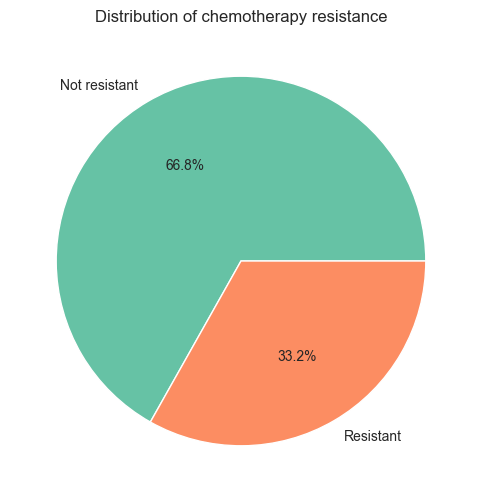

In [1620]:
# Visualize the distribution of chemotherapy resistance 

# get counts of values for each of the categories from chemoresistance df
resistance_counts = chemoresistance_df["Chemotherapy_Resistance"].value_counts()

# create figure and plot the piechart
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(resistance_counts, labels=["Not resistant", "Resistant"], autopct="%1.1f%%", colors=sns.color_palette("Set2"))
plt.title("Distribution of chemotherapy resistance")
plt.savefig("./images/chemotherapy_resistance_distribution.png") # save plot as image for later use in the presentation
plt.show()

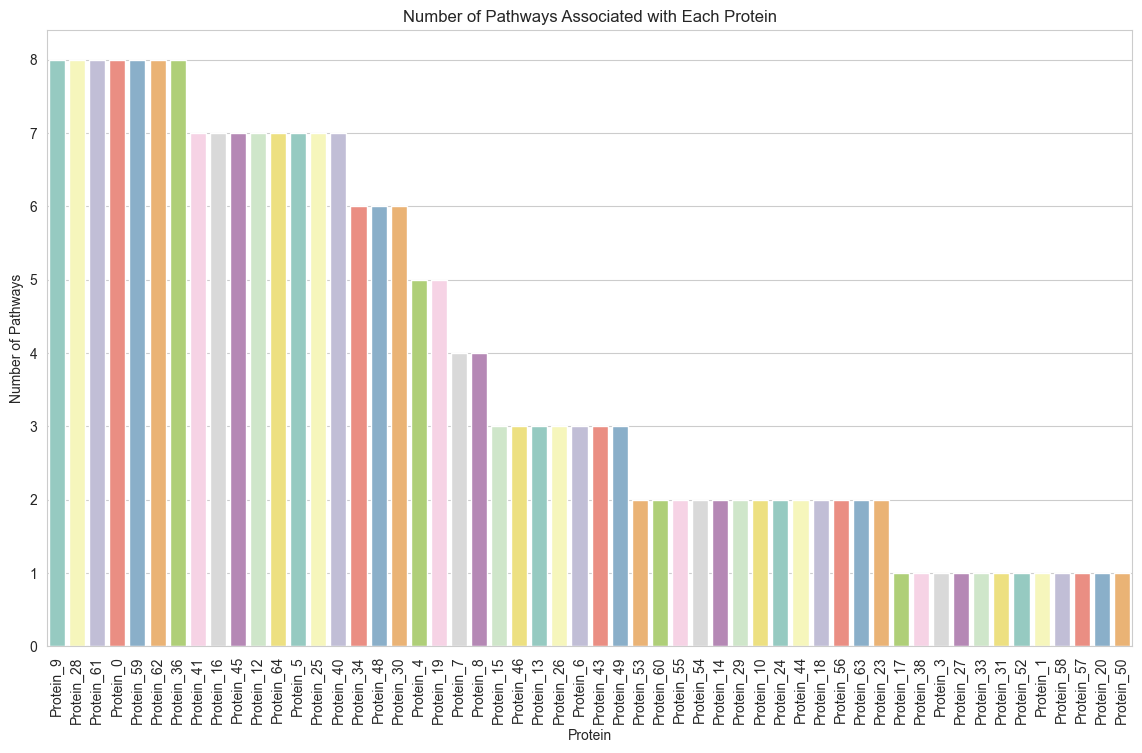

In [1621]:
# Count the number of pathways associated with each protein
protein_counts = pathways_df["Protein"].value_counts()

# Bar chart for protein counts
plt.figure(figsize=(14,8))
sns.barplot(x=protein_counts.index, hue=protein_counts.index, y=protein_counts.values, palette="Set3")
plt.title("Number of Pathways Associated with Each Protein")
plt.xlabel("Protein")
plt.ylabel("Number of Pathways")
plt.xticks(rotation=90)
plt.savefig("./images/pathways_protein_association.png") # save plot as image for later use in the presentation
plt.show()

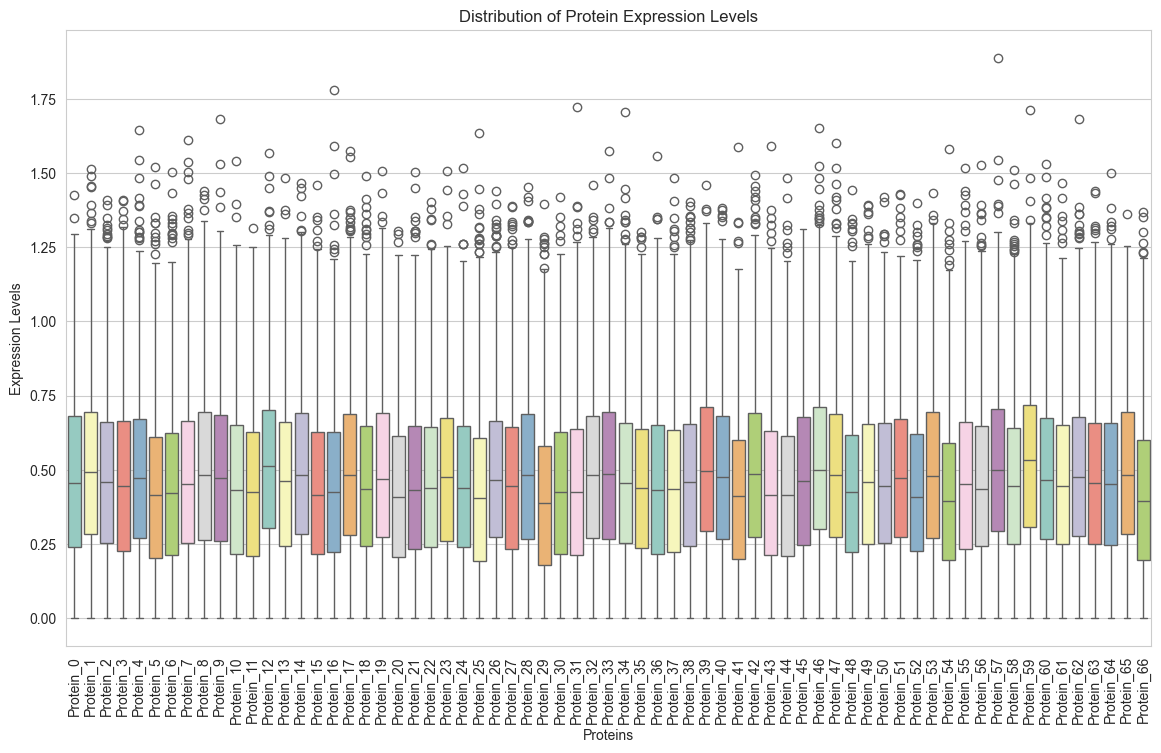

In [1622]:
# Box plot for protein expression levels
plt.figure(figsize=(14,8))
sns.boxplot(data=proteomics_df, palette="Set3")
plt.title("Distribution of Protein Expression Levels")
plt.xlabel("Proteins")
plt.ylabel("Expression Levels")
plt.xticks(rotation=90)
plt.savefig("./images/protein_expression_distribution.png") # save plot as image for later use in the presentation
plt.show()

### Part 2: Data Preparation

#### 2.1. Data for the Attention network

- We need to transform the data into the required format: [samples, pathways, features in pathways].

In [1623]:
# Create a dictionary mapping pathways to corresponding proteins
pathway_to_proteins = pathways_df.groupby('Pathway')['Protein'].apply(list).to_dict()

# Aggregate protein expression data by pathways - add the chemoresistance for later
attention_network_dataset = [
    [proteomics_df.loc[cell_line, proteins].values for proteins in pathway_to_proteins.values()]
    for cell_line in proteomics_df.index
]

# Convert to numpy array
attention_network_dataset = np.array(attention_network_dataset)

In [1624]:
print(f"Shape of the transformed dataset: {attention_network_dataset.shape}")

Shape of the transformed dataset: (1889, 9, 23)


In [1625]:
# get overview of the features of sample 1, pathway 1
attention_network_dataset[0][0]

array([0.2708908 , 0.14255243, 0.92446987, 1.13630152, 0.45151636,
       0.69156702, 0.14511803, 0.78338559, 0.50570659, 0.80395768,
       0.60172271, 0.70774622, 0.30076726, 0.        , 0.15326382,
       0.47589595, 0.4514403 , 0.26334845, 0.03851669, 0.61569733,
       0.88094488, 0.5556858 , 0.97535028])

#### 2.2. Data for the Standard Neural Network

- The data used for the standard network should be reduced to samples with proteins in any pathway.
- We need to filter the dataset based on proteins present in all pathways.

In [1626]:
unique_proteins = pathways_df["Protein"].unique()
print(f"There are {len(unique_proteins)} unique proteins.")

There are 54 unique proteins.


In [1627]:
standard_network_dataset = np.array(proteomics_df[unique_proteins])
print(f"Shape of the transformed dataset: {standard_network_dataset.shape}")

Shape of the transformed dataset: (1889, 54)


In [1628]:
# overview of a single sample
standard_network_dataset[0]

array([0.2708908 , 0.14255243, 0.19717098, 0.60923294, 0.70677591,
       0.49871177, 0.03128247, 0.92446987, 0.73960986, 0.58660702,
       0.45151636, 1.13630152, 0.18533279, 0.5855156 , 0.78338559,
       0.43531336, 0.14511803, 0.69156702, 0.46438898, 0.14622542,
       0.17404703, 0.70443293, 0.50570659, 0.37322719, 0.80395768,
       0.52968553, 0.60172271, 0.26355869, 0.30076726, 0.62691851,
       0.5066052 , 0.70774622, 0.3282756 , 0.81556687, 0.15326382,
       0.        , 0.        , 0.47589595, 0.4514403 , 0.36602505,
       0.27489087, 0.16089921, 0.34538331, 0.26334845, 0.39731531,
       0.3429842 , 0.60269253, 0.68004737, 0.03851669, 0.61569733,
       0.88094488, 0.40854677, 0.5556858 , 0.97535028])

#### 2.3. Creation of DataLoaders

In [1629]:
# prepare the dataset class for the DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0] # length determined by number of instances

    def __getitem__(self, idx):
        features = torch.tensor(self.X[idx], dtype=torch.float32) # convert to torch of type float
        target = torch.tensor(self.y[idx], dtype=torch.float32)
        return features, target

In [1630]:
def prep_data_for_model(X, y, BATCH_SIZE, TEST_SIZE):
    
    # perform train_test_split to get training and test sets (70/30)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state=42)

    # data scaling

    scaler = StandardScaler()

    # scaling will be different if attention data
    if len(X.shape) == 3:
        num_features = X_train.shape[-1]
        X_train_reshaped = X_train.reshape(-1, num_features)
        X_train_normalized = scaler.fit_transform(X_train_reshaped)
        X_train = X_train_normalized.reshape(X_train.shape)
        
        X_test_reshaped = X_test.reshape(-1, num_features)
        X_test_normalized = scaler.transform(X_test_reshaped)
        X_test = X_test_normalized.reshape(X_test.shape)

    else:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # TRAIN DATA
    # create dataset
    train_dataset = CustomDataset(X_train, y_train)
    # create dataloader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # TEST DATA
    # convert array to tensor
    x_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    return train_loader, x_test_tensor, y_test

In [1631]:
# split the attention-network dataset into training and test sets
target = chemoresistance_df.loc[proteomics_df.index.values]["Chemotherapy_Resistance"].values
attention_train_loader, attention_x_test, attention_y_test = prep_data_for_model(attention_network_dataset, target, BATCH_SIZE=BATCH_SIZE, TEST_SIZE=TEST_SIZE)

In [1632]:
print(f"Size of the training set for the attention network: {len(attention_train_loader.sampler)}")
print(f"Size of the test set: {attention_x_test.shape[0]}")

Size of the training set for the attention network: 1511
Size of the test set: 378


In [1633]:
attention_x_test.shape

torch.Size([378, 9, 23])

In [1634]:
# split the standard-network dataset into training and test sets
standard_train_loader, standard_x_test, standard_y_test = prep_data_for_model(standard_network_dataset, target, BATCH_SIZE=BATCH_SIZE, TEST_SIZE=TEST_SIZE)

In [1635]:
print(f"Size of the training set for the standard network: {len(standard_train_loader.sampler)}")
print(f"Size of the test set: {standard_x_test.shape[0]}")

Size of the training set for the standard network: 1511
Size of the test set: 378


### Part 3: Networks Classes

#### 3.1. MultiHead Attention Class

In [1636]:
# create class for the model using LightningModule
class MultiHeadAttentionModel(L.LightningModule):
    def __init__(self, input_dim, LEARNING_RATE, HIDDEN_DIM_1, HIDDEN_DIM_2, out_dim, NUM_HEADS):
        super().__init__()

        # input parameters
        self.input_dim = input_dim
        self.LEARNING_RATE = LEARNING_RATE
        self.HIDDEN_DIM_1 = HIDDEN_DIM_1
        self.HIDDEN_DIM_2 = HIDDEN_DIM_2
        self.out_dim = out_dim
        self.NUM_HEADS = NUM_HEADS
        
        self.mul_head_attention = torch.nn.MultiheadAttention(embed_dim=input_dim, num_heads=self.NUM_HEADS)
        self.linear_1 = torch.nn.Linear(9 * self.input_dim, self.HIDDEN_DIM_1)
        self.linear_2 = torch.nn.Linear(self.HIDDEN_DIM_1, self.HIDDEN_DIM_2)
        self.linear_3 = torch.nn.Linear(self.HIDDEN_DIM_2, out_dim)
        self.relu = torch.nn.ReLU()
        self.loss_func = torch.nn.BCELoss()
        self.dropout = torch.nn.Dropout(0.5)  

    def forward(self, x):
        x = x.permute(1, 0, 2)  # Shape: [pathways, samples, features]
        # Multi-head attention
        x, att_weights = self.mul_head_attention(x, x, x)  # Shape: [pathways, samples, features]
        x = x.permute(1, 0, 2)  # Shape: [samples, pathways, features]
        # Flatten for fully connected layers
        x = x.flatten(start_dim=1)  # Shape: [samples, pathways * features]
        # Fully connected layers
        x = self.relu(self.linear_1(x))
        x = self.dropout(x)
        x = self.relu(self.linear_2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.linear_3(x)) 
        return x, att_weights

    def training_step(self, batch, batch_idx):
        # split x and y
        x, y = batch 
        # perform predictions - weights output not needed
        preds, _ = self.forward(x) 
        # calculate and return loss
        loss = self.loss_func(preds.view(-1), y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.LEARNING_RATE)
        return optimizer

#### 3.2. Standard Network Class

In [1637]:
class StandardNeuralNetwork(L.LightningModule):
    def __init__(self, input_dim, LEARNING_RATE, HIDDEN_DIM_1, HIDDEN_DIM_2, out_dim):
        super().__init__()

        # input parameters
        self.input_dim = input_dim
        self.LEARNING_RATE = LEARNING_RATE
        self.HIDDEN_DIM_1 = HIDDEN_DIM_1
        self.HIDDEN_DIM_2 = HIDDEN_DIM_2
        self.out_dim = out_dim

        # layers
        self.linear_1 = torch.nn.Linear(self.input_dim, self.HIDDEN_DIM_1) 
        self.linear_2 = torch.nn.Linear(self.HIDDEN_DIM_1, HIDDEN_DIM_1)
        self.linear_3 = torch.nn.Linear(self.HIDDEN_DIM_1, self.HIDDEN_DIM_2)
        self.linear_4 = torch.nn.Linear(self.HIDDEN_DIM_2, self.out_dim)
        self.relu = torch.nn.ReLU()

        # loss function
        self.loss_func = torch.nn.BCELoss()

    def forward(self, x):
        x = self.relu(self.linear_1(x))
        x = self.relu(self.linear_2(x))
        x = self.relu(self.linear_3(x))
        output = self.linear_4(x)
        output = torch.sigmoid(output)
        return output

    def training_step(self, batch, batch_idx):
        # split x and y
        x, y = batch 
        preds = self.forward(x) 
        # calculate and return loss
        loss = self.loss_func(preds.view(-1), y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.LEARNING_RATE)
        return optimizer

#### 3.2. Train-Test pipeline

In [1638]:
def train_and_test(lightning_module, model, MAX_EPOCHS, train_data_loader, x_test, y_test, attention):

    # TRAINING STEPS

    # Initialize the Lightning Trainer
    trainer = lightning_module.Trainer(max_epochs=MAX_EPOCHS, log_every_n_steps=10)
        
    # Train the model
    trainer.fit(model, train_data_loader)

    # TESTING STEPS
    
    # set model to evaluation state
    model.eval()

    # perform forward pass to test data
    with torch.no_grad():
        if attention:
            preds, attention_weights = model(x_test)
        else:
            preds = model(x_test)

    # evaluation metrics
    # to get the scores from the sklearn metrics, we need to:
    # convert the predictions to binary values 0,1 and to numpy
    preds = (preds > 0.5).int().numpy()
    f1_result = f1_score(y_test, preds)
    mcc = matthews_corrcoef(y_test, preds)

    print("-------------------------------------------")
    print(f"F1-Score: {f1_result}")
    print(f"Matthews Correlation Coefficient: {mcc}")

    if attention:
        return attention_weights

### 4. Execution and Results

#### 4.1. MultiHead Attention Model

In [1639]:
attention_model = MultiHeadAttentionModel(
    input_dim=attention_train_loader.dataset[0][0].shape[1],
    LEARNING_RATE = LEARNING_RATE,
    HIDDEN_DIM_1 = HIDDEN_DIM_1,
    HIDDEN_DIM_2 = HIDDEN_DIM_2,
    out_dim = 1,
    NUM_HEADS = NUM_HEADS
)

attention_weights = train_and_test(L, attention_model, MAX_EPOCHS, attention_train_loader, attention_x_test, attention_y_test, attention=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type               | Params | Mode 
------------------------------------------------------------------
0 | mul_head_attention | MultiheadAttention | 2.2 K  | train
1 | linear_1           | Linear             | 53.2 K | train
2 | linear_2           | Linear             | 32.9 K | train
3 | linear_3           | Linear             | 129    | train
4 | relu               | ReLU               | 0      | train
5 | loss_func          | BCELoss            | 0      | train
6 | dropout            | Dropout            | 0      | train
------------------------------------------------------------------
88.5 K    Trainable params
0         Non-trainable params
88.5 K    Total params
0.354     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
d:\Learning\virtual_env\Lib\site-packages\pytorch_lightning\trainer\conne

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


-------------------------------------------
F1-Score: 0.3791469194312796
Matthews Correlation Coefficient: 0.15184527824972274


After training and testing, attention weights are extracted. The following section provides an overview of the weights.

In [1640]:
# check the shape of the attention weights matrix
print(f"Shape of attention weights: {attention_weights.shape}")

Shape of attention weights: torch.Size([378, 9, 9])


The analysis focus will be the attention of the samples to each pathway. Thus, the averaged weights across pathways will be computed, making the visualization easier.

In [1641]:
# get averaged weights across dimension 1 - pathways
averaged_weights = attention_weights.mean(dim=1) 

# create dataframe for easier processing - set columns to the unique pathways list
weights_df = pd.DataFrame(averaged_weights, columns=pathways_df["Pathway"].unique())

In [1642]:
# get overview of the values
weights_df.head()

,Pathway_0,Pathway_1,Pathway_2,Pathway_3,Pathway_4,Pathway_5,Pathway_6,Pathway_7,Pathway_8
0,0.102505,0.110332,0.115169,0.107913,0.109504,0.108934,0.126214,0.115114,0.104314
1,0.110039,0.109745,0.108328,0.105455,0.107475,0.107067,0.113333,0.124009,0.114549
2,0.102833,0.103035,0.143256,0.107890,0.108330,0.110486,0.115222,0.110169,0.098779
3,0.106253,0.118987,0.125764,0.108800,0.103842,0.109740,0.104715,0.109125,0.112775
4,0.107532,0.109552,0.109308,0.110988,0.128258,0.113106,0.116638,0.103961,0.100657


In [1643]:
# the weights of the pathways (axis 1) should sum close to 1 for each sample 
weights_df.sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
373    1.0
374    1.0
375    1.0
376    1.0
377    1.0
Length: 378, dtype: float32

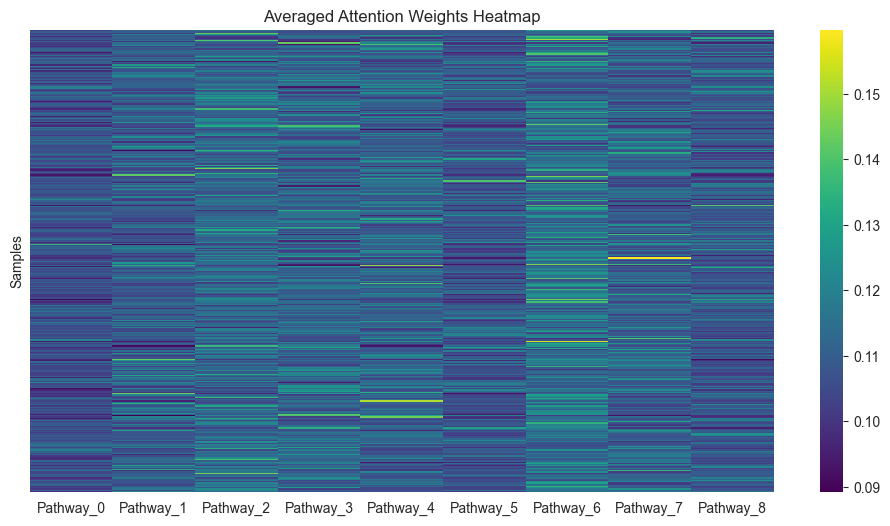

In [1644]:
# plot a heatmap of the weights across samples for general overview

plt.figure(figsize=(12, 6))
sns.heatmap(weights_df, cmap="viridis", yticklabels=False)
plt.ylabel("Samples")
plt.title("Averaged Attention Weights Heatmap")
plt.show()

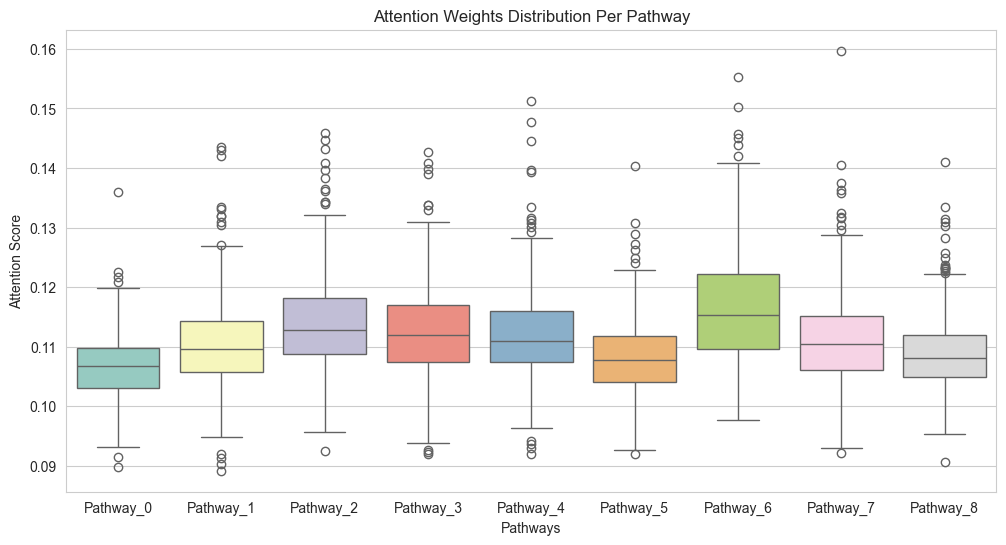

In [1645]:
# get the distribution of attention weights over pathways
plt.figure(figsize=(12, 6))
sns.boxplot(data=weights_df, palette="Set3")
plt.xlabel("Pathways")
plt.ylabel("Attention Score")
plt.title("Attention Weights Distribution Per Pathway")
plt.show()


#### 4.2. Standard Neural Network

In [1646]:
standard_model = StandardNeuralNetwork(
    input_dim=standard_train_loader.dataset[0][0].shape[0],
    LEARNING_RATE = LEARNING_RATE,
    HIDDEN_DIM_1 = HIDDEN_DIM_1,
    HIDDEN_DIM_2 = HIDDEN_DIM_2,
    out_dim = 1,
)

train_and_test(L, standard_model, MAX_EPOCHS, standard_train_loader, standard_x_test, standard_y_test, attention=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | linear_1  | Linear  | 14.1 K | train
1 | linear_2  | Linear  | 65.8 K | train
2 | linear_3  | Linear  | 32.9 K | train
3 | linear_4  | Linear  | 129    | train
4 | relu      | ReLU    | 0      | train
5 | loss_func | BCELoss | 0      | train
----------------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.452     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
d:\Learning\virtual_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


-------------------------------------------
F1-Score: 0.34782608695652173
Matthews Correlation Coefficient: 0.11770853077346483
